Introduction:
In the the table there are 4 columns f: observed frequency , x and y: coordinated on celestial sphere , p: power
the measuring units of the rest frequencies is MHz . 
HI (1420.4057) , OH (1612.2310 , 1665.4018, 1667.3590) , H20 (22235.0799) , NH3 (23694.5060 , 23722.6340, 23870.1300)

In [13]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter


data=pd.read_excel('/Users/User/Downloads/spectrum_data_excel.xlsx' , header=None)
data.columns=("f", "x", "y", "p")

rest_f=[1420.4057, 1612.2310, 1665.4018, 1667.3590, 22235.0799, 23694.5060, 23722.6340, 23870.1300]

Gaussian distribution. The smoothing out process doesn't work.

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\lmfit\model.py:1053: UserWarning: The keyword argument A does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


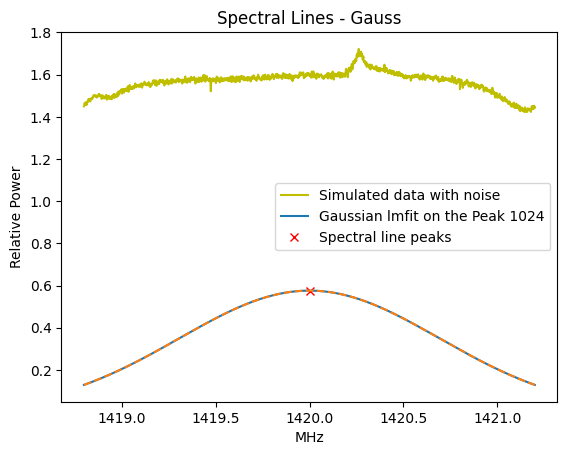

Peak: (1420.0, 0.5758234458213407)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 18
    # data points      = 2048
    # variables        = 2
    chi-square         = 2.2280e-25
    reduced chi-square = 1.0890e-28
    Akaike info crit   = -131862.898
    Bayesian info crit = -131851.648
    R-squared          = 1.00000000
[[Variables]]
    sigma:  0.69282024 +/- 4.9353e-16 (0.00%) (init = 1)
    mu:     1419.99941 +/- 5.8196e-16 (0.00%) (init = 1420)


In [14]:
std = np.std(data.f)
mn = np.mean(data.f)
def gaussian(x, sigma , mu):
    A = 1/ (sigma * np.sqrt(2*np.pi))
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

gvalues= gaussian(data.f, std , mn)
maxg = np.max(gvalues)
X_values = data.f
Y_values = np.array(gvalues)
smoothed_y = gaussian_filter(gvalues , std)
peaks, _ = find_peaks(smoothed_y , prominence = None)
gmodel = Model(gaussian)
results = {}

for i in peaks:
    results[i] = gmodel.fit(Y_values, A=1, mu=X_values[i], sigma=1, x=X_values, method='least_squares')


plt.plot(data.f , data.p , color= 'y', label= 'Simulated data with noise')

for i in peaks:
    plt.plot(data.f, results[i].best_fit, '-', label=f'Gaussian lmfit on the Peak {i}')

plt.plot(X_values[peaks], Y_values[peaks], 'rx', label='Spectral line peaks')

for i, result in results.items():
    plt.plot(X_values, result.best_fit, '--')

plt.xlabel('MHz')
plt.ylabel('Relative Power')
plt.title('Spectral Lines - Gauss')
plt.legend()
plt.show()

for i, result in results.items():
    print(f"Peak: ({X_values[i]}, {Y_values[i]})")
    print(result.fit_report())

Rolling mean . The function find_peaks also doesn;t work here. It doesn't show correctly the values of the (f,p) of the peak. It also needs an addition to put the f of the peak in an array.

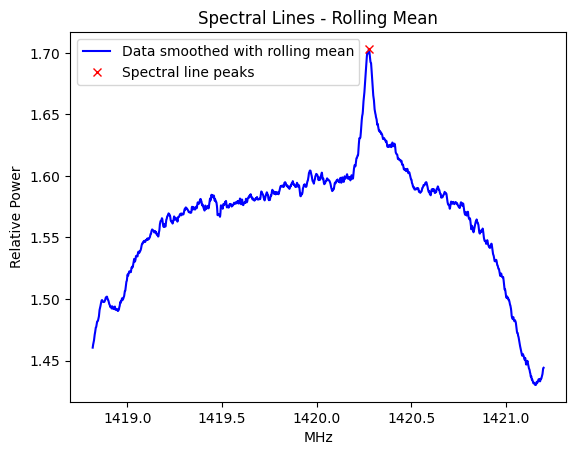

[1259]
Peak2: (1420.0, 1.6009389333333333)
True peak: ( 1420.275391 , 1.7031462666666666 )


In [26]:
data['rolp']=data['p'].rolling(15).mean()
max_p=data['rolp'].max()
max_fobs = data.loc[data['rolp'].idxmax(), 'f']

peaks2, _ = find_peaks(data.rolp , prominence = 0.1)

plt.plot(data.f , data.rolp , color= 'b', label= 'Data smoothed with rolling mean')
plt.plot(data.f[peaks2], data.rolp[peaks2], 'rx', label='Spectral line peaks')
plt.xlabel('MHz')
plt.ylabel('Relative Power')
plt.title('Spectral Lines - Rolling Mean')
plt.legend()
plt.show()


print(f"Peak2: ({data.f[i]}, {data.rolp[i]})")
print("True peak:", "(",max_fobs, ",", max_p,")")

Fitting for rest lines. In the argument named a it will have an input of the array with the x values of the peaks found previously. It is not ready yet.

In [16]:
fo = 0
def fitting(a, b, c):
    results=[]
    for x in a:
        for y in b:
            df = np.abs(x - y)
            if np.any(df <= 0.5):
                condition = np.where(df <= 0.5)[0][0]
                fo = b[condition]
                # print(fo)
                h = np.linspace(np.min(c), np.max(c))
                x_line = np.full_like(h, fo)
                
                results.append(x)
                
            else:
                continue

    return results, y , fo, h

results, y, fo, h = fitting(data['f'], rest_f , data['p'])

Radial Velocity ( km/s)

In [17]:
def u(f):
    c=3*10**5
    return ((fo -f)/fo )*c

data['u']=u(data.f)

def inv(u):
    c=3*10**5
    return fo - (u/c)*fo

Visualise the data.

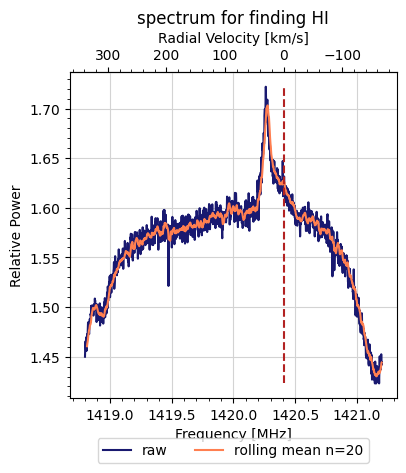

In [18]:
from matplotlib.ticker import AutoMinorLocator

fig, ax1=plt.subplots()
ax1.plot(data.f, data.p, color='midnightblue', label='raw')
ax1.plot(data.f , data.rolp, color='coral', label='rolling mean n=20')
#if line :
ax1.plot(fo*np.ones(len(h)),h, color='firebrick', linestyle='--', linewidth =1.5 )
ax1.set_xlabel("Frequency [MHz]")
ax1.set_ylabel("Relative Power")
ax1.yaxis.get_ticklocs(minor=True)
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()
ax1.set_box_aspect(1.0)

ax2=ax1.secondary_xaxis('top', functions=(u, inv))
ax2.set_xlabel("Radial Velocity [km/s]")
ax2.xaxis.get_ticklocs(minor = True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())

plt.grid(True, linestyle ="solid", c="lightgrey")
plt.title("spectrum for finding HI")
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.subplots_adjust(bottom=0.2)
plt.show()
